# Optimal Load Scheduling Model

## Sets

- `T`: set of time periods, indexed by `t`  
- `L`: set of controllable loads, indexed by `ℓ`



## Parameters

- $\Delta t$ — duration of each time period  
- $c_t$ — electricity price at time $t$  
- $P^{\text{base}}_t$ — base (non-controllable) load at time $t$  
- $P^{\max}$ — maximum allowable grid power  
- $E_\ell^{\text{req}}$ — required total energy for load $\ell$  
- $P_\ell^{\max}$ — maximum instantaneous power for load $\ell$  
- $\mathcal{T}_\ell$ — allowed operating time window of load $\ell$  
- $\lambda$ — weight/penalty for peak demand



## Decision + Auxiliary Variables

- $x_{\ell,t} \ge 0$: power assigned to load $\ell$ at time $t$  
- $y_{\ell,t} \in \{0,1\}$: 1 if load $\ell$ is ON at time $t$  
- $P^{\text{grid}}_t \ge 0$: grid power at time $t$  
- $P^{\text{peak}} \ge 0$: peak grid power



# Optimization Model

## Objective Function

Minimize energy cost + peak penalty:

$$
\min_{x,y,P^{\text{grid}},P^{\text{peak}}}
\left(
\sum_{t \in T} \Delta t \, c_t \, P^{\text{grid}}_t
\;+\;
\lambda \, P^{\text{peak}}
\;+\;
\nu \, \sum_{\substack{\ell \in L \\ t \in T}} y_{\ell, t}
\right).
$$



# Constraints

### 1. Power balance

$$
P^{\text{grid}}_t
=
P^{\text{base}}_t
+
\sum_{\ell \in L} x_{\ell,t},
\qquad \forall t \in T.
$$



### 2. Load power limits (linked to on/off variable)

$$
0 \le x_{\ell,t}
\le
P_\ell^{\max} \, y_{\ell,t},
\qquad \forall \ell \in L,\; \forall t \in T.
$$



### 3. Energy requirement

$$
\sum_{t \in T} \Delta t \, x_{\ell,t}
\ge
E_\ell^{\text{req}},
\qquad \forall \ell \in L.
$$



### 4. Allowed operating window

$$
y_{\ell,t} = 0, \qquad \forall t \notin \mathcal{T}_\ell.
$$



### 5. Maximum grid-power constraint

$$
P^{\text{grid}}_t \le P^{\max}, \qquad \forall t \in T.
$$



### 6. Peak-demand definition

$$
P^{\text{grid}}_t \le P^{\text{peak}}, \qquad \forall t \in T.
$$



### 7. Variable domains

$$
x_{\ell,t} \ge 0, \qquad
P^{\text{grid}}_t \ge 0, \qquad
P^{\text{peak}} \ge 0,
$$

$$
y_{\ell,t} \in \{0,1\}.
$$



# Model Summary

This MILP formulation:

- Schedules flexible loads in time  
- Minimizes time-varying electricity cost  
- Controls peak demand  
- Respects device and window constraints  





In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyscipopt import Model, quicksum

In [2]:
##### DATA #####


# -----------------------------
# Sets and time discretization
# -----------------------------
T = range(24)        # 24 time periods (e.g. hours in a day)
L = range(10)        # 10 controllable loads
Delta_t = 1.0        # [h] length of each time slot

# -----------------------------
# Tariff and base demand
# -----------------------------
# Time-of-use price [THB/kWh] (example profile)
c = {}
for t in T:
    if 0 <= t <= 5:
        c[t] = 2.0   # off-peak
    elif 6 <= t <= 16:
        c[t] = 3.0   # mid-peak
    elif 17 <= t <= 21:
        c[t] = 5.0   # on-peak / evening peak
    else:  # 22, 23
        c[t] = 3.0

# Non-controllable base demand [kW] (example)
P_base = {t: 5.0 for t in T}
for t in range(18, 23):
    P_base[t] = 10.0  # evening base a bit higher

# Max feeder demand [kW]
P_max = 50.0

# Weight for peak demand penalty (λ in the LaTeX model)
lam = 20.0

# -----------------------------
# Load profiles
# -----------------------------
# For each load ℓ:
#   - E_req[ℓ] : required energy [kWh] over the day
#   - P_max_load[ℓ] : maximum power [kW]
#   - T_allowed[ℓ] : allowed time window as a set of periods

E_req = {
    0: 8.0, 
    1: 3.0, 
    2: 4.0, 
    3: 2.0, 
    4: 6.0, 
    5: 2.5, 
    6: 1.5, 
    7: 3.5, 
    8: 2.0, 
    9: 1.0  
}

P_max_load = {
    0: 3.6,  
    1: 1.5,
    2: 1.5,
    3: 2.0,
    4: 3.0,
    5: 1.0,
    6: 1.0,
    7: 2.5,
    8: 1.5,
    9: 1.0
}

# Different allowed windows for each load
T_allowed = {
    0: set(range(20, 24)) | set(range(0, 7)),
    1: set(range(8, 20)),    
    2: set(range(18, 24)),   
    3: set(range(10, 18)),   
    4: set(range(5, 10)),    
    5: set(range(0, 24)),    
    6: set(range(0, 24)),    
    7: set(range(12, 22)),   
    8: set(range(9, 13)),    
    9: set(range(14, 19))    
}



In [3]:
# -----------------------------
# Build the SCIP model
# -----------------------------
m = Model("optimal_load_scheduling_scip")

# Decision variables
# x[l,t] : load power [kW]
x = {}
# y[l,t] : on/off (binary)
y = {}
# P_grid[t] : grid power [kW]
P_grid = {}
# P_peak : peak demand [kW]
P_peak = m.addVar(lb=0.0, vtype="C", name="P_peak")

for l in L:
    for t in T:
        x[l, t] = m.addVar(lb=0.0, vtype="C", name=f"x[{l},{t}]")
        y[l, t] = m.addVar(lb=0.0, ub=1.0, vtype="B", name=f"y[{l},{t}]")

for t in T:
    P_grid[t] = m.addVar(lb=0.0, vtype="C", name=f"P_grid[{t}]")

# Objective:
#   sum_t Δt * c_t * P_grid_t + λ * P_peak
obj = quicksum(Delta_t * c[t] * P_grid[t] for t in T) + lam * P_peak + quicksum(y[l, t] for l in L for t in T)
m.setObjective(obj, "minimize")

# -----------------------------
# Constraints
# -----------------------------

# (1) Power balance: P_grid_t = P_base_t + sum_ℓ x_{ℓ,t}
for t in T:
    m.addCons(
        P_grid[t] == P_base[t] + quicksum(x[l, t] for l in L),
        name=f"power_balance[{t}]"
    )

# (2) Device power bounds and linking to on/off variable
for l in L:
    for t in T:
        m.addCons(
            x[l, t] <= P_max_load[l] * y[l, t],
            name=f"device_max[{l},{t}]"
        )

# (3) Energy requirement for each load: sum_t Δt x_{ℓ,t} ≥ E_ℓ^req
for l in L:
    m.addCons(
        quicksum(Delta_t * x[l, t] for t in T) >= E_req[l],
        name=f"energy_req[{l}]"
    )

# (4) Allowed operating window: y_{ℓ,t} = 0 for t ∉ T_allowed[ℓ]
for l in L:
    for t in T:
        if t not in T_allowed[l]:
            m.addCons(
                y[l, t] == 0.0,
                name=f"time_window[{l},{t}]"
            )

# (5) Maximum demand: P_grid_t ≤ P_max
for t in T:
    m.addCons(
        P_grid[t] <= P_max,
        name=f"max_demand[{t}]"
    )

# (6) Peak demand definition: P_grid_t ≤ P_peak
for t in T:
    m.addCons(
        P_grid[t] <= P_peak,
        name=f"peak_def[{t}]"
    )



In [4]:
# -----------------------------
# Solve
# -----------------------------
m.optimize()
status = m.getStatus()

presolving:
(round 1, fast)       131 del vars, 155 del conss, 0 add conss, 421 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       286 del vars, 311 del conss, 0 add conss, 576 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
(round 3, exhaustive) 286 del vars, 311 del conss, 0 add conss, 577 chg bounds, 0 chg sides, 0 chg coeffs, 109 upgd conss, 0 impls, 0 clqs
   (0.0s) probing: 51/109 (46.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) symmetry computation finished: 8 generators found (max: 1500, log10 of symmetry group size: 3.46) (symcode time: 0.00)
dynamic symmetry handling statistics:
   orbitopal reduction:        2 components: 6x5, 12x3
   orbital re

In [5]:
# -----------------------------
# Report solution
# -----------------------------
if status == "optimal":
    sol = m.getBestSol()
    obj_val = m.getObjVal()
    print(f"\nOptimal objective value = {obj_val:.2f}")
    print(f"Peak demand P_peak      = {sol[P_peak]:.2f} kW\n")

    # Print time series of grid power
    print("Time  P_grid  Base  Flex (sum x_l,t)")
    for t in T:
        flex = sum(sol[x[l, t]] for l in L)
        print(f"{t:02d}    {sol[P_grid[t]]:6.2f}  {P_base[t]:4.1f}  {flex:6.2f}")

    # Print schedule per load (times where it is ON)
    print("\nLoad schedules (time periods where y_{l,t} = 1):")
    for l in L:
        on_times = [t for t in T if sol[y[l, t]] > 0.5]
        if on_times:
            print(f"Load {l}: ON at hours {on_times}")
        else:
            print(f"Load {l}: never ON (check E_req and window)")
else:
    print(f"No optimal solution found. SCIP status = {status}")


Optimal objective value = 818.50
Peak demand P_peak      = 10.50 kW

Time  P_grid  Base  Flex (sum x_l,t)
00      7.00   5.0    2.00
01     10.10   5.0    5.10
02      6.30   5.0    1.30
03      8.60   5.0    3.60
04      5.00   5.0    0.00
05      8.00   5.0    3.00
06      8.00   5.0    3.00
07      5.00   5.0    0.00
08      6.50   5.0    1.50
09      8.00   5.0    3.00
10      7.50   5.0    2.50
11      5.00   5.0    0.00
12      7.50   5.0    2.50
13      6.00   5.0    1.00
14      6.00   5.0    1.00
15      5.00   5.0    0.00
16      5.00   5.0    0.00
17      5.00   5.0    0.00
18     10.50  10.0    0.50
19     10.50  10.0    0.50
20     10.50  10.0    0.50
21     10.50  10.0    0.50
22     10.50  10.0    0.50
23      6.50   5.0    1.50

Load schedules (time periods where y_{l,t} = 1):
Load 0: ON at hours [1, 2, 3]
Load 1: ON at hours [8, 9]
Load 2: ON at hours [18, 19, 20, 21, 22, 23]
Load 3: ON at hours [10]
Load 4: ON at hours [5, 6]
Load 5: ON at hours [0, 1, 2]
Load 6: ON 

SCIP status: optimal
Objective value : 818.500
Solving time    : 0.030 s
Branch-&-bound nodes : 1
Relative MIP gap     : 0.000e+00



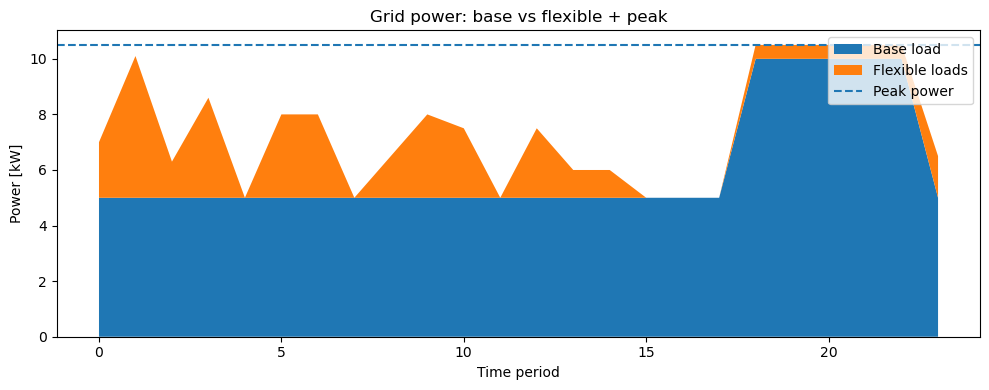

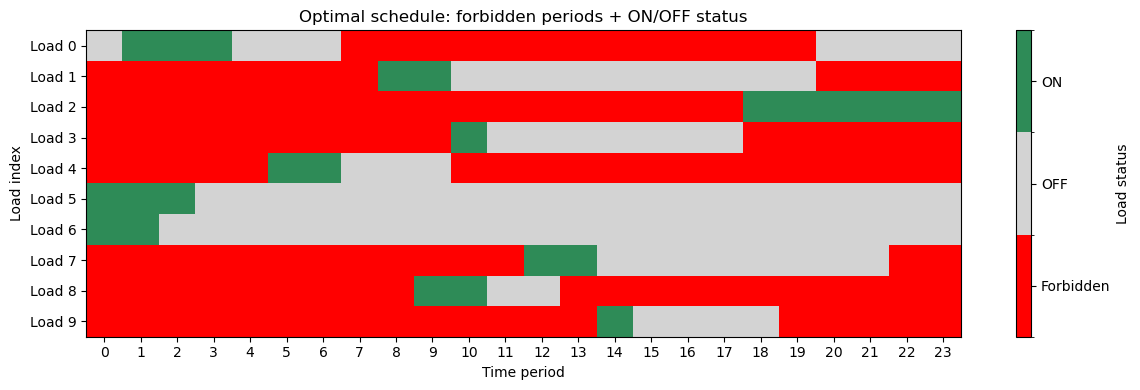

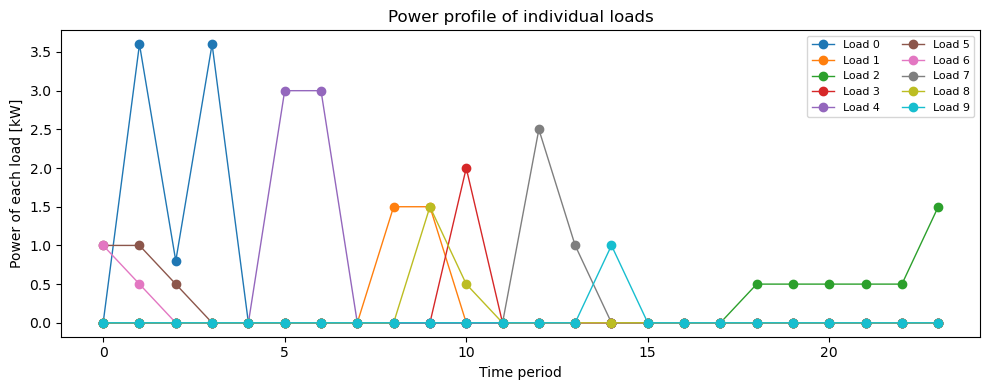

In [6]:
# ============================================
# Visualization of optimal schedule & performance
# ============================================

# Check status and grab best solution
status = m.getStatus()
print("SCIP status:", status)

if status != "optimal":
    # You can still visualize the best incumbent, but let's warn:
    print("Warning: model is not proven optimal. Showing best known solution.\n")

sol = m.getBestSol()

# ----- Solver performance stats -----
solve_time = m.getSolvingTime()
num_nodes  = m.getNTotalNodes()
gap        = m.getGap()
obj_val    = m.getObjVal()

print(f"Objective value : {obj_val:.3f}")
print(f"Solving time    : {solve_time:.3f} s")
print(f"Branch-&-bound nodes : {num_nodes}")
print(f"Relative MIP gap     : {gap:.3e}\n")

# ----- Time series: base vs flexible vs total grid power -----
time_points = list(T)
grid_power  = [sol[P_grid[t]] for t in T]
base_power  = [P_base[t] for t in T]
flex_power  = [grid_power[i] - base_power[i] for i in range(len(T))]

plt.figure(figsize=(10, 4))
plt.stackplot(time_points, base_power, flex_power, labels=["Base load", "Flexible loads"])
plt.axhline(sol[P_peak], linestyle="--", linewidth=1.5, label="Peak power")
plt.xlabel("Time period")
plt.ylabel("Power [kW]")
plt.title("Grid power: base vs flexible + peak")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ----- Unified heatmap: forbidden vs OFF vs ON -----
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# State encoding:
#   -1 = forbidden hour
#    0 = allowed & OFF   (y = 0)
#    1 = allowed & ON    (y = 1)
state = np.zeros((len(L), len(T)), dtype=int)

for i, l in enumerate(L):
    for j, t in enumerate(T):
        if t not in T_allowed[l]:
            state[i, j] = -1
        elif sol[y[l, t]] > 0.5:
            state[i, j] = 1
        else:
            state[i, j] = 0

# Colors for each state
# red = forbidden, lightgray = allowed OFF, green = allowed ON
cmap = ListedColormap(["red", "lightgray", "seagreen"])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(state, cmap=cmap, norm=norm, aspect="auto")

# Colorbar with labels
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(["Forbidden", "OFF", "ON"])
cbar.set_label("Load status", rotation=90)

# Axis labels
ax.set_yticks(range(len(L)))
ax.set_yticklabels([f"Load {l}" for l in L])
ax.set_xticks(range(len(T)))
ax.set_xticklabels(list(T))

ax.set_xlabel("Time period")
ax.set_ylabel("Load index")
ax.set_title("Optimal schedule: forbidden periods + ON/OFF status")

plt.tight_layout()
plt.show()


# ----- Optional: power per load over time (line plot) -----
plt.figure(figsize=(10, 4))
for l in L:
    load_profile = [sol[x[l, t]] for t in T]
    plt.plot(time_points, load_profile, marker="o", linewidth=1, label=f"Load {l}")
plt.xlabel("Time period")
plt.ylabel("Power of each load [kW]")
plt.title("Power profile of individual loads")
plt.legend(loc="upper right", ncol=2, fontsize=8)

# ----- SUMMARY -----
plt.tight_layout()
# plt.savefig("profile.png")
plt.show()


------